In [10]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [29]:
data = pd.read_csv('WAG_C_M.csv', sep = ';', parse_dates=['month'], dayfirst=True, index_col=['month'])

In [30]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

посмотрим на данные

Text(0.5,0,'month')

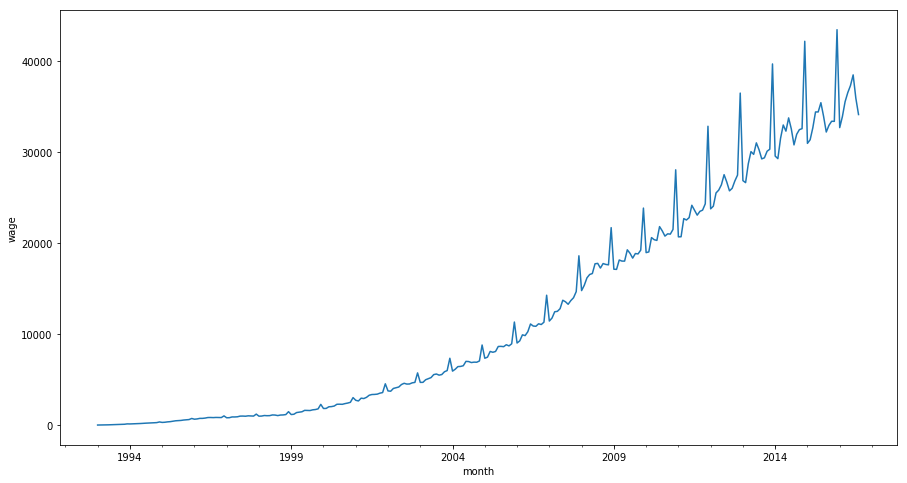

In [31]:
plt.figure(figsize = (15, 8))
data['WAG_C_M'].plot()
plt.ylabel('wage')
plt.xlabel('month')

на графике видим явный тренд на увеличение заработной платы, также можно отметить годовую сезонность изменений. Дисперсия ряда увеличивается с течением времени.
Очевидно, что гипотеза о стационарности на данный момент не будет принята, но тем не менее применим критерий Дики-Фуллера, просто потому, что мы можем (во имя науки, конечно же).

Критерий Дики-Фуллера: p=0.9918495954854735


<Figure size 7200x720 with 0 Axes>

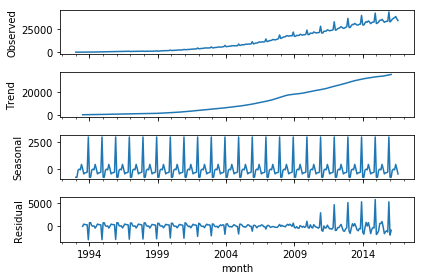

In [40]:
plt.figure(figsize = (100,10))
sm.tsa.seasonal_decompose(data['WAG_C_M']).plot()
print("Критерий Дики-Фуллера: p=" + str(sm.tsa.stattools.adfuller(data['WAG_C_M'])[1]))